## Initialisation

In [261]:
import copy
import random
import time
import pprint

from matplotlib import pyplot as plt
from pymongo import MongoClient
import numpy as np


# Init
mongo = MongoClient('localhost', 27017)
db = mongo['citeos']
collection_villes = db['villes']
collection_routes = db['routes']
collection_clients = db['clients']

num_clients_FR = list(map(lambda x: x['id_client'], collection_clients.aggregate([{"$match" : {'est_client': True, 'type': 'frais'}}])))
num_clients_PA = list(map(lambda x: x['id_client'], collection_clients.aggregate([{"$match" : {'est_client': True, 'type': 'particulier'}}])))
num_clients_PR = list(map(lambda x: x['id_client'], collection_clients.aggregate([{"$match" : {'est_client': True, 'type': 'prisonnier'}}])))

num_clients_FR.append(0)
num_clients_PA.append(0)
num_clients_PR.append(0)

roads_FR = np.array(list(collection_routes.find({'id_ville_1': {'$in': num_clients_FR}, 'id_ville_2': {'$in': num_clients_FR}})))
roads_PA = np.array(list(collection_routes.find({'id_ville_1': {'$in': num_clients_PA}, 'id_ville_2': {'$in': num_clients_PA}})))
roads_PR = np.array(list(collection_routes.find({'id_ville_1': {'$in': num_clients_PR}, 'id_ville_2': {'$in': num_clients_PR}})))

num_clients_FR.remove(0)
num_clients_PA.remove(0)
num_clients_PR.remove(0)

## Fonction Voisin

In [262]:
def neighborhood(circuit):
    """
    Cette fonction est un generateur de tous les voisins valides d'une solution
    """
    for i in range (1, len(circuit) - 2):
        neighbor_circuit = circuit.copy()
        neighbor_circuit[i], neighbor_circuit[i + 1] = neighbor_circuit[i + 1], neighbor_circuit[i]
        yield neighbor_circuit

## Fonction Recuperation Routes

In [263]:
def import_roads(cities, roads):
    cities.append(0)
    return np.array([road for road in roads if road['id_ville_1'] in cities and road['id_ville_2'] in cities])


## Fonction Score

In [264]:
def search(node,roads, circuit):
    for item in roads:
        if (item["id_ville_1"] == circuit[node] and item["id_ville_2"] == circuit[node + 1]) or (item["id_ville_1"] == circuit[node + 1] and item["id_ville_2"] == circuit[node]):
            return item

def circuit_score_test(circuit, roads):
    """
    Cette fonction retourne le score d'un circuit eulerien, cela permettra de comparer les differents voisins entre eux
    """
    score = 0
    for i in range(0, len(circuit) - 1):
        #on recupere la bonne route
        #road = [item for item in roads if (item["id_ville_1"] == circuit[i] and item["id_ville_2"] == circuit[i + 1]) or (item["id_ville_1"] == circuit[i + 1] and item["id_ville_2"] == circuit[i])][0]
        #road = next(item for item in roads if (item["id_ville_1"] == circuit[i] and item["id_ville_2"] == circuit[i + 1]) or (item["id_ville_1"] == circuit[i + 1] and item["id_ville_2"] == circuit[i]))
        #road = list(collection_routes.find({'id_ville_1': {'$in': [i, i + 1]}, 'id_ville_2': {'$in': [i, i + 1]}}))[0]
        #road = next(filter(lambda item: (item["id_ville_1"] == circuit[i] and item["id_ville_2"] == circuit[i + 1]) or (item["id_ville_1"] == circuit[i + 1] and item["id_ville_2"] == circuit[i]), roads))#
        road = search(i, roads, circuit)
        #on verifie si la route est oriente ou non, si oui, on cherche le bon sens
        if road['est_oriente']: score += road['poids_1'] if road['id_ville_1'] == circuit[i] else road['poids_2']
        else: score += road['poids']
    return score

def circuit_score(circuit, roads, header):
    """
    Cette fonction retourne le score d'un circuit eulerien, cela permettra de comparer les differents voisins entre eux
    """
    score = 0
    for i in range(0, len(circuit) - 1):
        #on recupere la bonne route
        #road = [item for item in roads if (item["id_ville_1"] == circuit[i] and item["id_ville_2"] == circuit[i + 1]) or (item["id_ville_1"] == circuit[i + 1] and item["id_ville_2"] == circuit[i])][0]
        #road = next(filter(lambda item: (item["id_ville_1"] == circuit[i] and item["id_ville_2"] == circuit[i + 1]) or (item["id_ville_1"] == circuit[i + 1] and item["id_ville_2"] == circuit[i]), roads))
        name = f"{circuit[i]}/{circuit[i + 1]}" if circuit[i] > circuit[i + 1] else f"{circuit[i + 1]}/{circuit[i]}"
        road = roads[header[name]]
        #road = search(i, roads, circuit)
        #on verifie si la route est oriente ou non, si oui, on cherche le bon sens
        if road['est_oriente']: score += road['poids_1'] if road['id_ville_1'] == circuit[i] else road['poids_2']
        else: score += road['poids']
    return score




test_circuit = [2,12,13,27,31,36,41,56,73,77]
print(num_clients_PA)
a = copy.deepcopy(num_clients_PA)
r = import_roads(a, roads_PA)

start = time.perf_counter()


dic = {}
for idx, b in enumerate(r):
    dic[b["route"]] = idx


print(time.perf_counter() - start)

start = time.perf_counter()
for _ in range(0, 5):
    f = circuit_score(a, r, dic)

print(time.perf_counter() - start)

start = time.perf_counter()

for _ in range(0, 5):
    e = circuit_score_test(a, r)
print(time.perf_counter() - start)

print(f)
print(e)

[2, 3, 5, 9, 13, 32, 35, 39, 40, 45, 46, 57, 58, 63, 68, 71, 80, 84, 96, 98, 126, 127, 133, 134, 141, 152, 153, 158, 160, 162, 172, 173, 179, 189, 190, 200, 206, 220, 223, 227, 244, 265, 281, 302, 303, 309, 324, 325, 326, 328, 332, 342, 379, 384, 386, 388, 391, 399, 413, 416, 418, 421, 424, 430, 431, 432, 433, 446, 452, 466, 467, 481, 484, 491, 492, 505, 511, 517, 519, 521, 528, 539, 546, 563, 568, 592, 598, 606, 626, 633, 634, 642, 643, 648, 656, 667, 673, 675, 677, 682, 683, 686, 694, 696, 698, 704, 705, 706, 710, 713, 722, 726, 731, 736, 781, 782, 783, 789, 805, 810, 818, 820, 825, 829, 838, 847, 848, 852, 859, 866, 873, 875, 887, 890, 891, 892, 895, 899, 909, 911, 913, 915, 922, 928, 930, 932, 933, 938, 945, 965, 973, 975, 976, 990, 997, 1028, 1030, 1032, 1041, 1045, 1055, 1068, 1074, 1078, 1084, 1092, 1095, 1103, 1107, 1116, 1118, 1130, 1140, 1142, 1153, 1159, 1185, 1191, 1214, 1217, 1218, 1229, 1240, 1243, 1244, 1251, 1254, 1265, 1266, 1270, 1275, 1280, 1297, 1300, 1304, 1312, 13

## Recherche Tabou

In [265]:
def tabu_search(initial_circuit, tabu_size, max_iteration, actual_roads, actual_roads_header):
    iteration = 1
    tabu_list = list()
    actual_circuit = initial_circuit.copy()

    best_actual_circuit = initial_circuit.copy()
    best_total_circuit = initial_circuit.copy()
    best_total_value = circuit_score(best_total_circuit, actual_roads, actual_roads_header)

    best_total_list = list()
    best_actual_list = list()

    while iteration <= max_iteration:
        iteration += 1
        best_actual_value = -1

        # on parcourt les voisins de la solution courante
        for neighbor in neighborhood(actual_circuit):
            if neighbor not in tabu_list : score = circuit_score(neighbor, actual_roads, actual_roads_header)
            else: continue
            if score <= best_actual_value or best_actual_value == -1:
                best_actual_value = score
                best_actual_circuit = neighbor.copy()

        # on met a jour la meilleur solution rencontree depuis le debut
        if best_actual_value < best_total_value:
            best_total_circuit = best_actual_circuit.copy()
            best_total_value = best_actual_value

        best_total_list.append(best_total_value)
        best_actual_list.append(best_actual_value)

        actual_circuit = best_actual_circuit.copy()

        if len(tabu_list) >= tabu_size: tabu_list.pop(0)
        tabu_list.append(actual_circuit.copy())

    return best_total_circuit, best_total_list, best_actual_list

## Multi-start

In [266]:
def tabu_multi_start(number, iteration, shuffled, actual_roads, actual_roads_header, tabu_size):
    best_local_score = -1
    best_local_circuit = []
    for i in range(0, number):
        shuffled_circuit = shuffled.copy()
        shuffled_circuit.append(0)
        shuffled_circuit.insert(0, 0)
        bc, bt, ba= tabu_search(shuffled_circuit, tabu_size, iteration, actual_roads, actual_roads_header)
        actual_score = circuit_score(bc, actual_roads, actual_roads_header)

        if best_local_score == -1 or actual_score < best_local_score:
            best_local_score = actual_score
            best_local_circuit = bc

        random.shuffle(shuffled)
    return [best_local_circuit, best_local_score]

## Graphe vers circuits

In [267]:
def create_circuits(clients_list, roads_list, k):

    k = k - len(clients_list)

    total_of_clients = sum(len(client_list) for client_list in clients_list)
    number_of_clients = [len(client_list) for client_list in clients_list]
    trucks_for_lists = [int(k * percentage) for percentage in [len(client_list) / total_of_clients for client_list in clients_list]]

    while sum(trucks_for_lists) != k: trucks_for_lists[random.randint(0, len(trucks_for_lists) - 1)] += 1

    print(number_of_clients)

    origins = [0] * len(clients_list)
    clients_per_k = [noc // tfl for noc, tfl in zip(number_of_clients, trucks_for_lists)]
    difference = [noc % (cpk * tfl) for noc, cpk, tfl in zip(number_of_clients, clients_per_k, trucks_for_lists)]
    best_circuits = [[] for _ in range (len(clients_list))]

    for idx, client_list in enumerate(clients_list):
        passed = [origins[idx],]
        actual_node = random.choice(client_list)
        for truck in range(0, trucks_for_lists[idx]):

            truck_circuit = [actual_node,]
            passed.append(actual_node)

            while len(truck_circuit) != clients_per_k[idx]:
                truck_circuit.append(get_closer_node(truck_circuit[-1], roads_list[idx], passed))
                passed.append(truck_circuit[-1])

            if difference[idx] > 0:
                difference[idx] -= 1
                truck_circuit.append(get_closer_node(truck_circuit[-1], roads_list[idx], passed))
                passed.append(truck_circuit[-1])

            if len(truck_circuit) % 6 == 0:
                actual_node = get_closer_node(truck_circuit[0], roads_list[idx], passed)
            else:
                actual_node = get_closer_node(truck_circuit[-1], roads_list[idx], passed)

            if truck == trucks_for_lists[idx] - 1:
                best_circuits[idx].append(truck_circuit[:int(len(truck_circuit) // 1.5)])
                best_circuits[idx].append(truck_circuit[int(len(truck_circuit) // 1.5):])
            else:
                best_circuits[idx].append(truck_circuit)
    return best_circuits



c = create_circuits([num_clients_FR, num_clients_PA, num_clients_PR], [roads_FR, roads_PA, roads_PR], 30)
tot = 0
totb = 0
print(c)
for i in c:
    totb += len(i)
    for j in i:
        tot += len(j)
print(tot)
print(len(num_clients_FR))
print(totb)

[328, 319, 339]


KeyboardInterrupt: 

In [ ]:
test  = [222, 786, 74, 627, 351, 758,6,7, 445, 700, 707, 478, 839, 53, 836, 127, 993, 437, 420, 666, 436, 252]
print(test[: int(len(test) // 1.5)])
print(test[int(len(test) // 1.5):])


## Glouton

In [ ]:
def get_closer_node(node, roads, ignored):
    min_weight = -1
    next_node = 0
    roads = [r for r in roads if r["id_ville_1"] not in ignored or r["id_ville_2"] not in ignored]
    for road in roads:
        if road['est_oriente']:
            if (road['id_ville_1'] == node) and (min_weight == -1 or min_weight > road['poids_1']):
                min_weight = road['poids_1']
                next_node = road['id_ville_2']
            elif (road['id_ville_2'] == node) and (min_weight == -1 or min_weight > road['poids_2']):
                min_weight = road['poids_2']
                next_node = road['id_ville_1']
        elif (min_weight > road['poids'] or  min_weight == -1) and (road["id_ville_1"] == node or road["id_ville_2"] == node):
            min_weight = road['poids']
            next_node = road['id_ville_1'] if road["id_ville_2"] == node else road['id_ville_2']

    return next_node

## Tests

In [ ]:
#circuits_per_type = create_circuits([num_clients_FR, num_clients_PA, num_clients_PR], [roads_FR, roads_PA, roads_PR], k)




[328, 319, 339]
Type de livraison n.0
[[0, 833, 790, 1286, 685, 488, 1666, 112, 699, 982, 785, 851, 1703, 1198, 1877, 77, 110, 1024, 628, 599, 146, 460, 1572, 0], 820]
[[0, 97, 652, 22, 1900, 1913, 872, 62, 213, 1696, 1552, 1091, 1257, 1600, 518, 36, 856, 7, 29, 1022, 455, 23, 792, 0], 984]
[[0, 591, 1417, 775, 787, 12, 469, 151, 1131, 1910, 1215, 985, 1858, 1566, 1186, 148, 94, 1474, 427, 867, 1986, 1292, 1147, 0], 651]
[[0, 1046, 456, 319, 1333, 1616, 506, 188, 1704, 1878, 377, 1770, 576, 122, 554, 315, 107, 381, 1424, 510, 1070, 1040, 1513, 0], 337]
[[0, 1701, 1329, 1, 548, 1480, 1750, 168, 1952, 1412, 479, 1809, 92, 1947, 1225, 1094, 886, 1006, 1864, 585, 1402, 1096, 534, 0], 587]
[[0, 1435, 75, 1076, 1314, 1011, 1044, 1207, 844, 226, 1760, 1832, 819, 1097, 1407, 1594, 1730, 1586, 69, 1146, 1367, 924, 198, 0], 809]
[[0, 1379, 1311, 1985, 711, 459, 496, 355, 169, 412, 1874, 1642, 1849, 1556, 1049, 494, 1062, 1061, 64, 1821, 66, 1712, 1613, 0], 637]
[[0, 1163, 10, 209, 660, 503, 1790

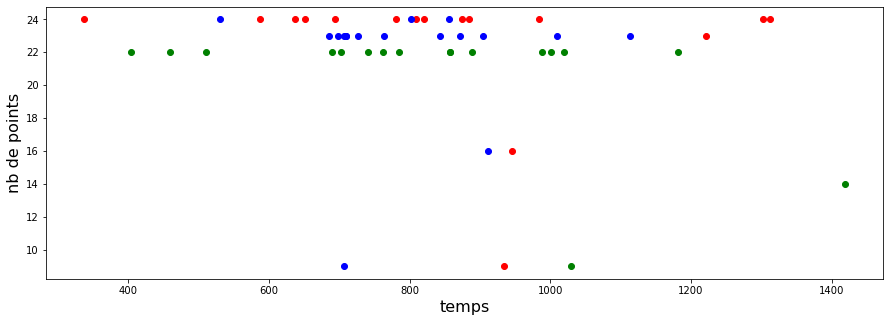

In [268]:
final = []
n = 5
it = 250
k = 50
ts = 80

nodes_all = [num_clients_FR, num_clients_PA, num_clients_PR]
roads_all = [roads_FR, roads_PA, roads_PR]
circuits_per_type = create_circuits(nodes_all, roads_all, k)

colors = ['red', 'green', 'blue']

start = time.perf_counter()
plt.figure(figsize=(15,5))


for i, circuits in enumerate(circuits_per_type):
    print(f"Type de livraison n.{i}")

    for j, circuit in enumerate(circuits):

        roads_content = import_roads(circuit.copy(), roads_all[i])
        roads_header = { road_content["route"]: idx for idx, road_content in enumerate(roads_content)}
        final.append(tabu_multi_start(n, it, circuit.copy(), roads_content, roads_header, ts))

        print(final[-1])

        plt.xlabel("temps", fontsize=16)
        plt.ylabel("nb de points", fontsize=16)
        plt.scatter(final[-1][1], len(final[-1][0]), color=colors[i],)

print(time.perf_counter() - start)
#print(final)

tot = 0

for i in final:
    print(i[0])
    tot += len(i[0]) - 2

print(tot)